# OLD FACES ANALISYS 

In this notebook we analyse the power in predicting IMT from the activation maps during the Old FACES task. By means of a nested cross-validation, we assessed the generalization of the model (outer loop) and the optimal value of the regularisation LASSO coefficient (inner loop). All the folds in the outer and inner loop have been generated in a stratified fashion way such that there are not differences between the training and test set in IMT as measured by a Kolmogorv-Smirnov test.

In [36]:
# Here the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join as opj
import seaborn as sns
import os
import time
from joblib import Parallel, delayed

from nilearn import masking, image, plotting
from sklearn.model_selection import (StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model.coordinate_descent import _alpha_grid
from scipy.stats import ks_2samp, pearsonr, zscore
from sklearn.utils import resample
from glob import glob

from statsmodels.formula import api as smf
from statsmodels.regression import linear_model

In [2]:
# The working directory
work_dir = os.path.abspath("../")

In [3]:
# For reproducibility
RANDOM_STATE = 0

In [4]:
# Mask with the greatest voxel coverage 
grey_mask = image.load_img(img=opj(work_dir,"data", "reslicedER_grey25grey25.nii"))
amygdala_mask = image.load_img(img=opj(work_dir, "data", "amygdala_resliced_to_iaps.nii"))

In [5]:
# The subjects from in the whole project folder
subjs_dats = glob(opj(work_dir, "data", "faces","*"))
subject_list = [path.split("/")[-1] for path in subjs_dats]

In [6]:
meta_data = pd.read_csv(opj(work_dir,  "data", "all_data.csv"))

In [7]:
# Here we select the subjects for each task
old_faces_subs = meta_data[~meta_data.ID_OF.isna()].ID_OF.astype(int).to_list()
print("The number of subjects performing OLD faces task is ", len(old_faces_subs))

The number of subjects performing OLD faces task is  427


In [8]:
# Here the IMT values for each task
y_old_faces =  meta_data[~meta_data.ID_OF.isna()].imt.values


## OLD FACES TASK


- contrast_case = AllFaces > Shapes

In [9]:
contrast_case = "OldFaces/con_0001.nii"

In [10]:
X = masking.apply_mask(imgs=[opj(work_dir, "data", "faces", str(sub), contrast_case) \
          for sub in old_faces_subs], mask_img = grey_mask)

In [11]:
discrete_old_faces = np.digitize(y_old_faces, np.quantile(y_old_faces, q=[0.2, 0.4, 0.6, 0.8]))

We can see that the training and test are not significantly different in terms of IMT, as measured by means of a Kolmogorov-Smirnov test

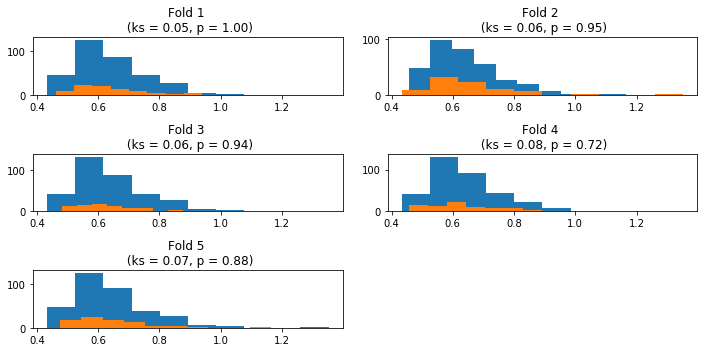

In [12]:
from scipy.stats import ks_2samp

cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE).split(np.zeros(len(discrete_old_faces)), 
                                                                                   discrete_old_faces)

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10,5))
axs = axs.flatten()

for ii, (train_index, test_index) in enumerate(cv):
    
    y_train, y_test = y_old_faces[train_index], y_old_faces[test_index]
    
    axs[ii].hist(y_train, label="training")
    axs[ii].hist(y_test, label="test")
    
    ks, p = ks_2samp(y_train, y_test)
    axs[ii].set_title("Fold {:d} \n (ks = {:.2f}, p = {:.2f})".format(ii + 1, ks, p))
    
fig.delaxes(axs[-1])
plt.tight_layout()

In [13]:
def fit_lasso(X_train, X_val, y_train, y_val, alpha):

    clf = Lasso(alpha=alpha, max_iter=1e5, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)
    
    return mean_squared_error(y_val, clf.predict(X_val))


def estim_opt(XX, yy, yy_discrete):

    cv_inner = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE)

    # This will generate a grid of alphas to optimise the model
    alphas = _alpha_grid(XX, yy, n_alphas = 100)

    XX_trains, XX_vals = [], []
    yy_trains, yy_vals = [], []
    
    for train_index, val_index in cv_inner.split(np.zeros(len(yy)), yy_discrete):
        X_train, X_val = XX[train_index], XX[val_index]
        y_train, y_val = yy[train_index], yy[val_index]

        ss = StandardScaler(with_std=False)
        pca = PCA()

        X_train_transform = pca.fit_transform(ss.fit_transform(X_train))
        X_val_transform = pca.transform(ss.transform(X_val))

        XX_trains.append(X_train_transform)
        XX_vals.append(X_val_transform)
        yy_trains.append(y_train)
        yy_vals.append(y_val)

    res_loops = []
    
    for X_train, X_val, y_train, y_val in zip(XX_trains, XX_vals, yy_trains, yy_vals):
        
        res_loops.append(Parallel(n_jobs=10)(delayed(fit_lasso)(X_train, X_val, y_train, y_val, alpha) for alpha in alphas))

    res_loops = np.array(res_loops)

    opt_alpha = alphas[np.argmin(res_loops.mean(axis=0))]

    #refit all data with this optimal alpha
    pip =  make_pipeline(StandardScaler(with_std=False), PCA(), 
                         Lasso(alpha=opt_alpha, max_iter=1e5, random_state=RANDOM_STATE))

    pip.fit(XX, yy)
    return pip

In [14]:
cv_outer = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE).split(np.zeros(len(discrete_old_faces)), 
                                                                                   discrete_old_faces)

y_pred = []
y_true = []

for train_index, test_index in cv_outer:

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_old_faces[train_index], y_old_faces[test_index]
    
    estim = estim_opt(X_train, y_train, discrete_old_faces[train_index])
    
    y_pred.append(estim.predict(X_test))
    y_true.append(y_test)

In [15]:
r, p = pearsonr(np.concatenate(y_true), np.concatenate(y_pred))
r

0.17575179244325276

In [16]:
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

In [17]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred), size=len(y_pred))
    
    corr_boot.append(np.corrcoef(y_pred[boot_idxs],
                                 y_true[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

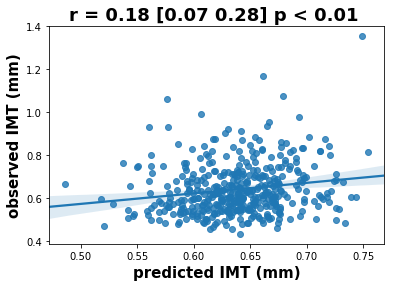

In [18]:
sns.regplot(y_pred, y_true)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")

In [156]:
observed_model = estim_opt(X, y_old_faces, discrete_old_faces)
weight_map = np.matmul(observed_model.named_steps['pca'].components_.T, 
                       observed_model.named_steps['lasso'].coef_)

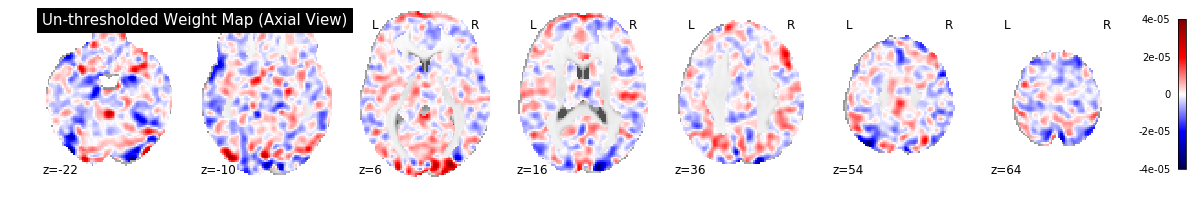

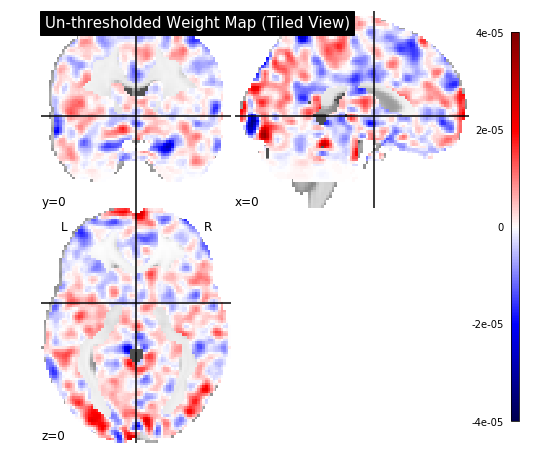

In [211]:
plotting.plot_stat_map(masking.unmask(weight_map, mask_img = grey_mask), 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic, 
                       title = "Un-thresholded Weight Map (Axial View)")

plotting.plot_stat_map(masking.unmask(weight_map, mask_img = grey_mask), 
                       threshold=0., display_mode='tiled', cut_coords=(0,0,0), cmap=plt.cm.seismic,
                      title = "Un-thresholded Weight Map (Tiled View)")
pass

In [166]:
n_boot = 1000

t_0 = time.time()

weight_map_boots = []

random_seed = 0
ii = 0
while ii < n_boot:
    try:
        X_boot, y_boot, y_discrete_boot = resample(X, y_old_faces, discrete_old_faces, 
                                                   random_state = random_seed)


        model_boot = estim_opt(X_boot, y_boot, y_discrete_boot)

        weight_map_boots.append(np.matmul(model_boot.named_steps['pca'].components_.T, 
                                          model_boot.named_steps['lasso'].coef_))

        if ii % 100 == 0:
            print("bootstrap iteration %d finished " % ii)
        ii += 1
        random_seed += 1          
    except:
        random_seed += 1 
        pass

t_f = time.time()
weight_map_boots = np.array(weight_map_boots)

bootstrap iteration 0 finished 
bootstrap iteration 100 finished 
bootstrap iteration 200 finished 
bootstrap iteration 300 finished 
bootstrap iteration 400 finished 
bootstrap iteration 500 finished 
bootstrap iteration 600 finished 
bootstrap iteration 700 finished 
bootstrap iteration 800 finished 
bootstrap iteration 900 finished 


In [183]:
#np.savez_compressed("resuts_old_faces.npz", weight_map = weight_map, weight_map_boots = weight_map_boots)

In [172]:
alpha = 0.05

low_ci = np.quantile(weight_map_boots, q = alpha/(2), axis=0)
high_ci = np.quantile(weight_map_boots, q=1-alpha/(2), axis=0)

In [173]:
mask_sig = low_ci*high_ci > 0

In [176]:
weight_map_thr = masking.unmask(mask_sig*weight_map, mask_img = grey_mask)

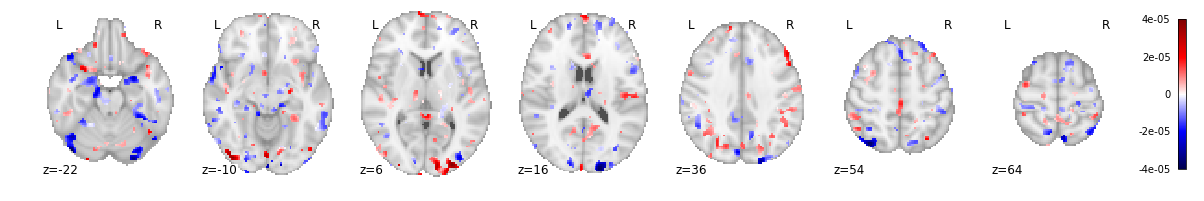

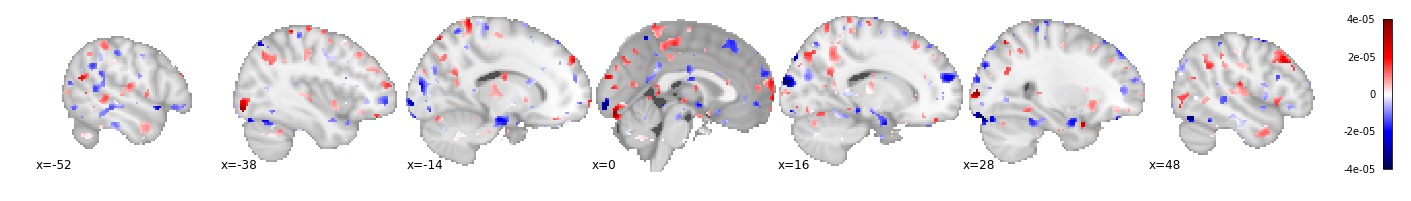

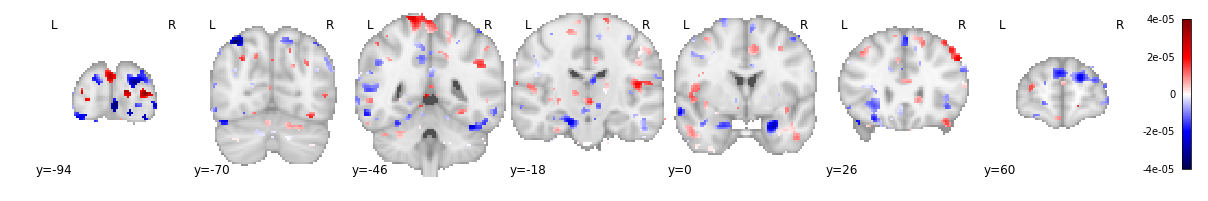

In [177]:
plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic)

plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='x', cmap=plt.cm.seismic)

plotting.plot_stat_map(weight_map_thr, 
                       threshold=0., display_mode='y', cmap=plt.cm.seismic)
pass

In [189]:
from nilearn.regions import connected_regions
voxel_size = 2 
k_voxels = 50

regions_extracted_img_pos, _ = connected_regions(masking.unmask(mask_sig*weight_map, mask_img = grey_mask), 
                                             min_region_size=k_voxels*voxel_size**3)

regions_extracted_img_neg, _ = connected_regions(masking.unmask(-1*mask_sig*weight_map, mask_img = grey_mask), 
                                             min_region_size=k_voxels*voxel_size**3)

In [190]:
new_data = np.zeros(grey_mask.shape)

for img in image.iter_img(regions_extracted_img_pos):
    new_data += img.get_data().copy()

for img in image.iter_img(regions_extracted_img_neg):
    new_data -= img.get_data().copy()
    
img_vox_thr = image.new_img_like(grey_mask, new_data)

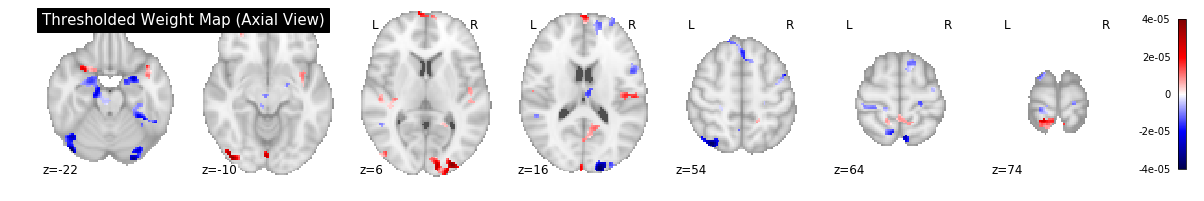

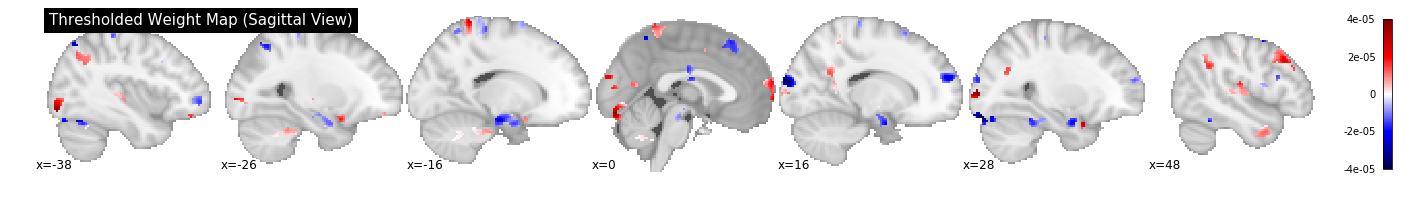

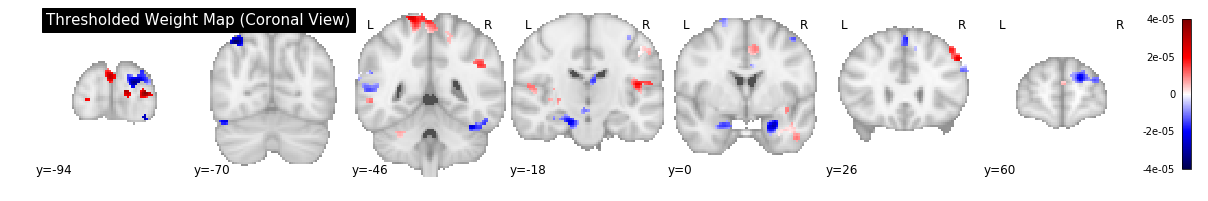

In [213]:
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='z', cmap=plt.cm.seismic, 
                       title = "Thresholded Weight Map (Axial View)")
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='x', cmap=plt.cm.seismic, 
                       title = "Thresholded Weight Map (Sagittal View)")
plotting.plot_stat_map(img_vox_thr, 
                       threshold=0., display_mode='y', cmap=plt.cm.seismic, 
                       title = "Thresholded Weight Map (Coronal View)")
pass

In [192]:
print(" Number of voxels with p < 0.05 and k = 50 = %d " % sum(abs(img_vox_thr.get_data().flatten())>0))

 Number of voxels with p < 0.05 and k = 50 = 7234 


In [193]:
from nilearn import datasets
from nilearn import surface

fsaverage = datasets.fetch_surf_fsaverage()

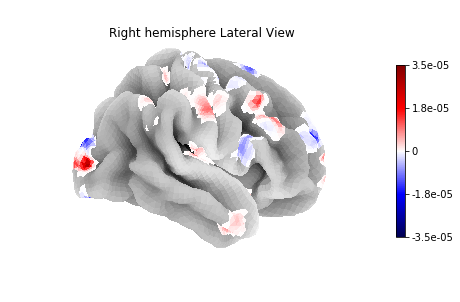

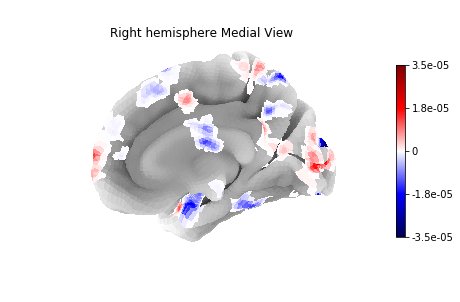

In [207]:
texture = surface.vol_to_surf(img_vox_thr, fsaverage.pial_right, radius=2.)


plotting.plot_surf_stat_map(fsaverage.pial_right, texture, hemi='right',
                            view= 'lateral', colorbar=True,
                            bg_map = fsaverage.sulc_right, cmap=plt.cm.seismic, 
                            title = "Right hemisphere Lateral View")

plotting.plot_surf_stat_map(fsaverage.pial_right, texture, hemi='right',
                            view= 'medial', colorbar=True, 
                            title = "Right hemisphere Medial View", 
                            bg_map = fsaverage.sulc_right, cmap=plt.cm.seismic)

plotting.show()

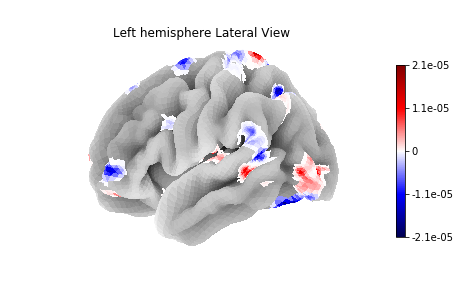

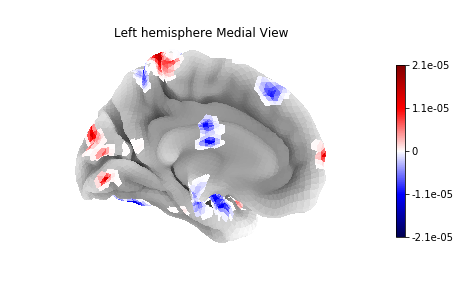

In [209]:
texture = surface.vol_to_surf(img_vox_thr, fsaverage.pial_left, radius=2.)

plotting.plot_surf_stat_map(fsaverage.pial_left, texture, hemi='left',
                            view= 'lateral', colorbar=True,
                            bg_map = fsaverage.sulc_left, cmap=plt.cm.seismic, 
                            title = "Left hemisphere Lateral View")

plotting.plot_surf_stat_map(fsaverage.pial_left, texture, hemi='left',
                            view= 'medial', colorbar=True, 
                            title = "Left hemisphere Medial View", 
                            bg_map = fsaverage.sulc_left, cmap=plt.cm.seismic)

plotting.show()

## ANCILLARY RESULTS

In [252]:
amygdala_mask_resampled = image.resample_img(amygdala_mask, target_affine= grey_mask.affine, 
                                             target_shape=grey_mask.shape, interpolation='nearest')

In [339]:
X_amygdala = masking.apply_mask(imgs=[opj(work_dir, "data", "faces", str(sub), contrast_case) \
                                      for sub in old_faces_subs], mask_img = amygdala_mask)

In [347]:
cv_outer = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE).split(np.zeros(len(discrete_old_faces)), 
                                                                                   discrete_old_faces)

y_pred_amygdala = []
y_true_amygdala = []

for train_index, test_index in cv_outer:

    X_train, X_test = X_amygdala[train_index], X_amygdala[test_index]
    y_train, y_test = y_old_faces[train_index], y_old_faces[test_index]
    
    estim = estim_opt(X_train, y_train, discrete_old_faces[train_index])
    
    y_pred_amygdala.append(estim.predict(X_test))
    y_true_amygdala.append(y_test)

y_true_amygdala = np.concatenate(y_true_amygdala)
y_pred_amygdala = np.concatenate(y_pred_amygdala)

In [348]:
r, p = pearsonr(y_true_amygdala, y_pred_amygdala)
r

0.1872385863610436

In [349]:
n_boot = 10000

corr_boot = []
np.random.seed(RANDOM_STATE)
for ii in range(n_boot):
    boot_idxs = np.random.choice(a = len(y_pred_amygdala), size=len(y_pred_amygdala))
    
    corr_boot.append(np.corrcoef(y_pred_amygdala[boot_idxs],
                                 y_true_amygdala[boot_idxs])[0,1])

corr_boot = np.array(corr_boot)

alpha = 0.05
l_ci = np.quantile(corr_boot, alpha/2.)
h_ci = np.quantile(corr_boot, 1 - alpha/2.)

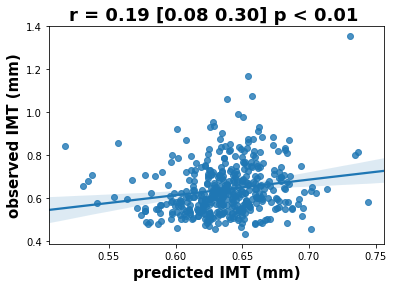

In [350]:
sns.regplot(y_pred_amygdala, y_true_amygdala)
plt.xlabel("predicted IMT (mm)", fontsize=15, fontweight = "bold")
plt.ylabel("observed IMT (mm)", fontsize=15, fontweight = "bold")
if p < 0.01:
    plt.title("r = %.2f [%.2f %.2f] p < 0.01 " % (r, l_ci, h_ci), fontsize=18, fontweight = "bold")
else:
    plt.title("r = %.2f [%.2f %.2f] p = %.2f " % (r, l_ci, h_ci, p),fontsize=18, fontweight = "bold")

In [391]:
lesion_mask_thomas = image.load_img("../data/amygdala_lesion_resliced_to_iaps.nii")

In [388]:
lesion_mask = image.math_img("img1 - img2", img1 = grey_mask, img2 = amygdala_mask)

In [394]:
X_lesion = masking.apply_mask(imgs=[opj(work_dir, "data", "faces", str(sub), contrast_case) \
                                      for sub in old_faces_subs], mask_img = lesion_mask_thomas)

In [396]:
cv_outer = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE).split(np.zeros(len(discrete_old_faces)), 
                                                                                   discrete_old_faces)

y_pred_lesion = []
y_true_lesion = []

for train_index, test_index in cv_outer:

    X_train, X_test = X_lesion[train_index], X_lesion[test_index]
    y_train, y_test = y_old_faces[train_index], y_old_faces[test_index]
    
    estim = estim_opt(X_train, y_train, discrete_old_faces[train_index])
    
    y_pred_lesion.append(estim.predict(X_test))
    y_true_lesion.append(y_test)

y_true_lesion = np.concatenate(y_true_lesion)
y_pred_lesion = np.concatenate(y_pred_lesion)

In [410]:
r, p = pearsonr(y_true_lesion, y_pred_lesion)
r

0.17329465246833894

Addig age, sex and CMR as regressors between predicted and observed values

In [20]:
old_faces_meta = meta_data[~meta_data.ID_OF.isna()]

In [21]:
# Put the meta data in the same order as predicted and 

cv = StratifiedKFold(n_splits=5,  shuffle = True, random_state=RANDOM_STATE).split(np.zeros(len(discrete_old_faces)), 
                                                                                   discrete_old_faces)

ordered_meta_data = pd.DataFrame({})
for train_index, test_index in cv:
    ordered_meta_data = pd.concat([ordered_meta_data, old_faces_meta.iloc[test_index,:]])

In [22]:
#Check if the observed IMT from the ordereed meta data is the same as the one used before
np.corrcoef(ordered_meta_data.imt, y_true)[0,1]

1.0

In [23]:
# Map extreme values to NaNs
ordered_meta_data.loc[ordered_meta_data.waist_circumference > 700, "waist_circumference"] = pd.np.nan
ordered_meta_data.loc[ordered_meta_data.HDL > 700, "HDL"] = pd.np.nan
ordered_meta_data.loc[ordered_meta_data.triglycerides > 700, "triglycerides"] = pd.np.nan
ordered_meta_data.loc[ordered_meta_data.glucose > 700, "glucose"] = pd.np.nan

In [24]:
ss = StandardScaler()

z_stouffer = np.nanmean(np.concatenate((ss.fit_transform(ordered_meta_data.loc[:, ["waist_circumference"]]), 
                                            ss.fit_transform(-1*ordered_meta_data.loc[:, ["HDL"]]),  
                                            ss.fit_transform(ordered_meta_data.loc[:, ["triglycerides"]]), 
                                            ss.fit_transform(ordered_meta_data.loc[:, ["glucose"]]), 
                                            ss.fit_transform(ordered_meta_data.loc[:, ["SBP"]])), axis=1), 
                        axis=1)

In [25]:
# Build ancillary data frame with observed and predicted values, age, sex and cmr
ancillary_df = pd.DataFrame({'y_true' : y_true, 
                             'y_pred': y_pred, 
                             'age': ordered_meta_data.age.values,
                             'sex': ordered_meta_data.sex.values,
                             'cmr': z_stouffer,
                            })

ancillary_df.head()

,y_true,y_pred,age,sex,cmr
0,0.51550,0.693493,31,1,0.356745
1,0.63231,0.651778,38,1,0.094953
2,0.79800,0.720183,54,1,1.474692
3,0.68238,0.693802,45,2,-0.166846
4,0.58256,0.585868,31,2,-0.032763


In [28]:
#standarise continuous variables 
ancillary_df.loc[:, ['y_true', 'y_pred', 'age', 'cmr']] = ancillary_df.loc[:, ['y_true', 'y_pred', 'age', 'cmr']].apply(zscore)

In [31]:
print("Observed IMT vs CMR RSquared = {:.3f}".format(smf.ols('y_true ~ cmr', 
                                                            data=ancillary_df).fit().rsquared))
print("Observed IMT vs CMR + Predicted IMT RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + y_pred', 
                                                                            data=ancillary_df).fit().rsquared))

Observed IMT vs CMR RSquared = 0.161
Observed IMT vs CMR + Predicted IMT RSquared = 0.173


In [32]:
print("Observed IMT vs CMR + Age + Sex RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + age + C(sex)', 
                                                            data=ancillary_df).fit().rsquared))
print("Observed IMT vs CMR + Age + Sex + Predicted IMT RSquared = {:.3f}".format(smf.ols('y_true ~ cmr + age + C(sex) + y_pred', 
                                                                        data=ancillary_df).fit().rsquared))

Observed IMT vs CMR + Age + Sex RSquared = 0.406
Observed IMT vs CMR + Age + Sex + Predicted IMT RSquared = 0.408


In [33]:
smf.ols('y_true ~ C(sex)*y_pred', data = ancillary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     6.830
Date:                Fri, 26 Jul 2019   Prob (F-statistic):           0.000167
Time:                        14:10:44   Log-Likelihood:                -595.79
No. Observations:                 427   AIC:                             1200.
Df Residuals:                     423   BIC:                             1216.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1227      0.069      1.790      0.074      -0.012       0.257
C(sex)[T.2]           -0.2356      0.095     -2.479      0.014      -0.422      -0.049
y_pred                 0.1342      0.070      1.928      0.055      -0.003       0.271
C(sex)[T.2]:y_pred     0.0767      0.095      0.806      0.421      -0.110       0.264
==============================================================================
Omnibus:                      116.560   Durbin-Watson:                   2.192
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.738
Skew:                           1.312   Prob(JB):                     7.46e-69
Kurtosis:                       6.278   Cond. No.                         2.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
smf.ols('y_true ~ age*y_pred', data = ancillary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     60.80
Date:                Fri, 26 Jul 2019   Prob (F-statistic):           1.06e-32
Time:                        14:10:48   Log-Likelihood:                -529.34
No. Observations:                 427   AIC:                             1067.
Df Residuals:                     423   BIC:                             1083.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0058      0.041     -0.142      0.887      -0.087       0.075
age            0.5235      0.041     12.742      0.000       0.443       0.604
y_pred         0.1049      0.041      2.529      0.012       0.023       0.186
age:y_pred     0.0399      0.040      1.008      0.314      -0.038       0.118
==============================================================================
Omnibus:                      138.168   Durbin-Watson:                   2.161
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              581.141
Skew:                           1.375   Prob(JB):                    6.41e-127
Kurtosis:                       8.010   Cond. No.                         1.26
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
smf.ols('y_true ~ cmr*y_pred', data=ancillary_df).fit(method="qr").summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 y_true   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     29.59
Date:                Fri, 26 Jul 2019   Prob (F-statistic):           2.20e-17
Time:                        14:10:56   Log-Likelihood:                -565.21
No. Observations:                 427   AIC:                             1138.
Df Residuals:                     423   BIC:                             1155.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0010      0.045      0.022      0.982      -0.087       0.089
cmr            0.3844      0.046      8.319      0.000       0.294       0.475
y_pred         0.1124      0.045      2.507      0.013       0.024       0.201
cmr:y_pred    -0.0060      0.044     -0.136      0.892      -0.092       0.080
==============================================================================
Omnibus:                      121.774   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              378.077
Skew:                           1.311   Prob(JB):                     7.97e-83
Kurtosis:                       6.792   Cond. No.                         1.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""